# PROJET ANALYSE DE DONNEES 
*Exploiter les spectres galactiques extraits du SDSS pour prédire certaines quantités physiques*


![Exemple visuel](1.jpg)


## Contexte et objectif

Ce projet a pour objectif de prédire le type d’objet céleste (STAR, GALAXY ou QSO) à partir de données issues du Sloan Digital Sky Survey (SDSS), en particulier la release DR17, qui fournit un vaste catalogue d’objets spectroscopiquement classés.

Nous avons structuré notre analyse autour de deux grands axes :

- Une tâche de **régression**, visant à estimer la valeur du redshift à partir des magnitudes photométriques, pour chaque classe séparément (galaxie, étoile, quasar).
- Une tâche de **classification**, où l’objectif est de prédire la classe d’un objet (STAR, GALAXY ou QSO) à partir de différentes combinaisons de variables (avec et uniquement redshift).

Nous avons utilisé l’algorithme **Random Forest**, qui offre de bonnes performances sans nécessiter trop de réglages, pour évaluer la pertinence des prédicteurs et mieux comprendre les différences entre objets proches et lointains.




## Extraction des données via SQL (SDSS)

**Accéder aux données**

Pour accéder aux données du Sloan Digital Sky Survey (SDSS), nous allons utiliser le site [SSDS Query / Casjobs](https://skyserver.sdss.org/CasJobs). Ce site permet d'exécuter des requêtes SQL sur les bases de données du SDSS et de télécharger les résultats.
Pour commencer, il faut se connecter ou créer un compte sur le site. Une fois connecté, on peut accéder à l'interface de requête SQL.

Après s'être rendu sur  le site [SSDS Query / Casjobs](https://skyserver.sdss.org/CasJobs), on a tapé la requête SQL suivante :
```bash
SELECT TOP 100000
    p.objID, p.ra, p.dec, p.u, p.g, p.r, p.i, p.z,
    p.run, p.rerun, p.camcol, p.field,
    s.specObjID, s.plate, s.mjd, s.fiberID,
    p.petroRad_u, p.petroRad_g, p.petroRad_r, p.petroRad_i, p.petroRad_z,
    p.petroFlux_u, p.petroFlux_g, p.petroFlux_r, p.petroFlux_i, p.petroFlux_z,
    p.petroR50_u, p.petroR50_g, p.petroR50_r, p.petroR50_i, p.petroR50_z,
    p.psfMag_u, p.psfMag_g, p.psfMag_r, p.psfMag_i, p.psfMag_z,
    p.expAB_u, p.expAB_g, p.expAB_r, p.expAB_i, p.expAB_z,
    s.z AS redshift, s.class
FROM PhotoObjAll AS p
JOIN SpecObjAll AS s ON p.specObjID = s.specObjID
```

On a choisi de prendre la table ```DR18``` comme contexte puis exécutons la requête. Une fois la commande prête, une page s'affiche avec la requête SQL suivante :
```bash
SELECT *
FROM  Mytable_0
```
```Mytable_0``` est le nom qu'on avons choisi de donner à notre table ici. Après exécution de cette requette, le téléchargement debutera et on peut à présent utiliser notre data !

# Chargement et aperçu des données

**Importer les bibliothèques et charger le dataset**

Une fois les données téléchargées, on peut les charger dans un notebook Python.  
Nous allons utiliser les bibliothèques suivantes :

- **pandas** : manipulation et exploration des données tabulaires
- **numpy** : calculs numériques et manipulation de tableaux
- **matplotlib** & **seaborn** : visualisation graphique
- **scikit-learn** : modélisation et machine learning

---

Ensuite, nous chargerons le dataset principal dans un DataFrame pour l’exploration.

Nous utilisons un extrait des données photométriques et spectroscopiques du SDSS.  
L’objectif est d’explorer ces données, de comprendre leur structure, puis de construire un modèle pour prédire le redshift des galaxies et des quasars.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix


# Load the SDSS dataset
df = pd.read_csv("data/dataset.csv")

**Vérification des valeurs manquantes.**

Nous vérifions si des valeurs manquantes sont présentes dans le jeu de données.
Les données manquantes doivent être traitées avant toute modélisation statistique ou phase d'entraînement.

In [2]:
df.isnull().sum().sum()

np.int64(0)

On observe qu'il n'y a pas de valeurs manquantes dans les colonnes du DataFrame. Donc on peut continuer l'analyse sans avoir à gérer des valeurs manquantes.

**Afficher toutes les colonnes pour l’exploration.**

Afin de comprendre la structure du jeu de données et d’inspecter les variables, nous nous assurons que toutes les colonnes sont visibles.
Cela permet d’identifier quelles colonnes correspondent à des mesures physiques, des métadonnées ou des étiquettes de classe.

In [3]:
# Désactiver toute limite d'affichage de colonnes
pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)  # Largeur illimitée
pd.set_option("display.max_colwidth", None)  # Largeur de chaque cellule

# Afficher les 10 premières lignes avec toutes les colonnes visibles
df.head(20)

,objID,ra,dec,u,g,r,i,z,run,rerun,camcol,field,specObjID,plate,mjd,fiberID,petroRad_u,petroRad_g,petroRad_r,petroRad_i,petroRad_z,petroFlux_u,petroFlux_g,petroFlux_r,petroFlux_i,petroFlux_z,petroR50_u,petroR50_g,petroR50_r,petroR50_i,petroR50_z,psfMag_u,psfMag_g,psfMag_r,psfMag_i,psfMag_z,expAB_u,expAB_g,expAB_r,expAB_i,expAB_z,redshift,class
0,1237648704046760145,198.367594,-0.356065,20.73523,18.85085,17.56961,17.08212,16.70905,752,301,3,366,332185036042299392,295,51985,162,4.617126,5.115590,4.721174,4.684702,5.162075,3.511168,25.518180,81.353650,129.18770,190.042100,1.767043,2.110504,2.036932,2.053084,2.261010,22.04871,20.27086,19.04142,18.61768,18.16375,0.849854,0.809568,0.763818,0.783755,0.719075,0.211824,GALAXY
1,1237648704046760198,198.428206,-0.384406,18.44623,17.23412,16.67523,16.29652,16.07245,752,301,3,366,332189708966717440,295,51985,179,5.532878,5.589859,5.600729,5.354244,5.304190,39.659250,125.105900,213.186100,290.01280,336.886800,2.734408,2.734028,2.720730,2.576809,2.524137,20.34698,19.26615,18.67339,18.33171,18.01228,0.529245,0.550424,0.521570,0.512080,0.483037,0.094445,GALAXY
2,1237648704046760550,198.336859,-0.218801,24.57992,22.96763,22.21550,22.45372,22.82691,752,301,3,366,332194107013228544,295,51985,195,43.766610,2.969290,1.533155,2.969510,43.757050,-0.040059,0.630245,1.160457,0.94205,1.493814,-9999.000000,1.056316,0.807809,1.243051,1.968449,24.25974,23.27652,22.62379,22.95598,22.58121,0.050000,0.150042,0.058668,0.050000,0.050000,3.174457,QSO
3,1237648704046825622,198.462136,-0.219281,19.30241,17.78075,16.90307,16.49114,16.18247,752,301,3,367,332188609455089664,295,51985,175,3.748427,5.855546,5.567865,5.369811,5.497572,16.157750,85.047600,182.182200,258.82040,339.042700,1.568756,2.160283,1.937312,1.818147,1.914507,20.18672,18.81749,17.95659,17.52794,17.23053,0.731522,0.780879,0.822669,0.840207,0.817236,0.121077,GALAXY
4,1237648704046825624,198.466124,-0.254391,20.16626,18.28559,17.22367,16.79652,16.40390,752,301,3,367,332186685309741056,295,51985,168,27.912360,4.671544,5.251847,4.817436,5.149425,13.775220,48.896820,132.852300,193.47120,281.822400,4.686791,2.066747,2.102676,2.048219,2.177020,21.22759,19.41046,18.40081,18.00373,17.58257,0.885392,0.743277,0.761695,0.732215,0.685603,0.138055,GALAXY
5,1237648704046825654,198.493224,-0.256808,19.09543,17.31310,16.35899,15.97224,15.63603,752,301,3,367,332188884332996608,295,51985,176,43.755040,2.868777,2.852538,2.827901,2.873691,25.439210,110.268800,266.156300,377.89710,505.926100,1.837784,1.378804,1.331829,1.306797,1.313619,19.92144,18.18361,17.26347,16.89209,16.56325,0.864026,0.721934,0.673505,0.681313,0.728872,0.138718,GALAXY
6,1237648704046825668,198.501137,-0.350658,19.93487,17.91528,16.87629,16.43629,16.04760,752,301,3,367,332188334577182720,295,51985,174,5.004049,5.202849,5.323276,5.051919,4.989447,9.111118,63.099300,167.760400,244.89990,347.871900,1.890661,2.171092,2.200809,2.088027,2.154626,21.20330,19.24600,18.25201,17.83184,17.43041,0.682248,0.835638,0.818189,0.862818,0.833072,0.120911,GALAXY
7,1237648704046825700,198.539702,-0.323055,20.59683,18.82568,17.65636,17.23815,16.86611,752,301,3,367,332185585798113280,295,51985,164,3.369139,3.106019,2.947591,3.086313,4.476436,4.846580,27.627040,81.833170,121.30410,183.102600,1.322552,1.391850,1.354546,1.380181,1.518395,21.31700,19.66862,18.55658,18.15280,17.82260,0.649986,0.780085,0.836987,0.815756,0.773011,0.176991,GALAXY
8,1237648704046891095,198.701398,-0.412739,19.09171,16.93303,16.00233,15.63252,15.43036,752,301,3,368,332182012385323008,295,51985,151,1.978415,1.582088,1.540958,1.525437,1.482557,22.903200,163.617100,391.359400,548.31160,664.196000,0.966614,0.807051,0.799581,0.800798,0.778099,19.26635,17.16443,16.26453,15.89750,15.76437,0.327707,0.071175,0.104135,0.096623,0.191604,-0.000061,STAR
9,1237648704046891118,198.597214,-0.268027,22.05573,19.20698,17.76519,16.86842,16.38345,752,301,3,368,333353816885848064,296,51984,318,1.959352,1.342583,1.255820,1.263818,1.168554,1.590325,19.834540,74.842530,168.

**Description des principales variables du jeu de données**

Le jeu de données SDSS contient de nombreuses variables issues des mesures photométriques et spectroscopiques. Voici un résumé des principales :

- **objID, specObjID** : identifiants uniques pour chaque objet et chaque spectre.
- **run, rerun, camcol, field, plate, mjd, fiberID** : métadonnées techniques liées à l’acquisition des images et des spectres.
- **ra** et **dec** : coordonnées célestes (ascension droite et déclinaison) qui localisent chaque objet dans le ciel. Elles sont utiles pour la cartographie, mais n’ont pas de lien direct avec les propriétés physiques à prédire.
- **u, g, r, i, z** : magnitudes apparentes dans différents filtres photométriques du SDSS, représentant la luminosité mesurée dans chaque bande. Ce sont des variables physiques essentielles pour l’analyse.
- **psfMag_*** : magnitudes mesurées selon la fonction d’étalement du point (PSF), adaptées aux objets ponctuels (étoiles, quasars).
- **petroRad_***, **petroFlux_***, **petroR50_*** : mesures de taille et de flux selon la méthode de Petrosian, principalement pour les galaxies.
- **expAB_*** : rapport d’axes issu d’un ajustement de profil exponentiel, lié à la forme de l’objet.
- **redshift** : décalage spectral mesuré par spectroscopie, indicateur de la distance cosmologique de l’objet. C’est la variable cible pour la régression.
- **class** : type d’objet céleste (GALAXY, STAR, QSO), utilisé pour la classification et l’analyse différenciée selon la nature de l’objet.

**Colonnes supprimées pour l’analyse**  
Certaines variables purement techniques ou redondantes (identifiants, métadonnées d’acquisition : `objID`, `specObjID`, `run`, `rerun`, `camcol`, `field`, `plate`, `mjd`, `fiberID`) sont supprimées avant la modélisation, car elles n’apportent pas d’information physique pertinente pour la prédiction.

Pour les détails sur la signification de chaque variable, on a consulté la documentation officielle du SDSS :  
[SDSS Data Model — Photometric and Spectroscopic Parameters](https://www.sdss.org/dr12/algorithms/magnitudes/)

In [4]:
df = df.drop(columns=[
    "objID", "specObjID", "run", "rerun", "camcol", "field", 
    "plate", "mjd", "fiberID",'ra', 'dec'
])

In [5]:
df.head(15)

,u,g,r,i,z,petroRad_u,petroRad_g,petroRad_r,petroRad_i,petroRad_z,petroFlux_u,petroFlux_g,petroFlux_r,petroFlux_i,petroFlux_z,petroR50_u,petroR50_g,petroR50_r,petroR50_i,petroR50_z,psfMag_u,psfMag_g,psfMag_r,psfMag_i,psfMag_z,expAB_u,expAB_g,expAB_r,expAB_i,expAB_z,redshift,class
0,20.73523,18.85085,17.56961,17.08212,16.70905,4.617126,5.115590,4.721174,4.684702,5.162075,3.511168,25.518180,81.353650,129.18770,190.042100,1.767043,2.110504,2.036932,2.053084,2.261010,22.04871,20.27086,19.04142,18.61768,18.16375,0.849854,0.809568,0.763818,0.783755,0.719075,0.211824,GALAXY
1,18.44623,17.23412,16.67523,16.29652,16.07245,5.532878,5.589859,5.600729,5.354244,5.304190,39.659250,125.105900,213.186100,290.01280,336.886800,2.734408,2.734028,2.720730,2.576809,2.524137,20.34698,19.26615,18.67339,18.33171,18.01228,0.529245,0.550424,0.521570,0.512080,0.483037,0.094445,GALAXY
2,24.57992,22.96763,22.21550,22.45372,22.82691,43.766610,2.969290,1.533155,2.969510,43.757050,-0.040059,0.630245,1.160457,0.94205,1.493814,-9999.000000,1.056316,0.807809,1.243051,1.968449,24.25974,23.27652,22.62379,22.95598,22.58121,0.050000,0.150042,0.058668,0.050000,0.050000,3.174457,QSO
3,19.30241,17.78075,16.90307,16.49114,16.18247,3.748427,5.855546,5.567865,5.369811,5.497572,16.157750,85.047600,182.182200,258.82040,339.042700,1.568756,2.160283,1.937312,1.818147,1.914507,20.18672,18.81749,17.95659,17.52794,17.23053,0.731522,0.780879,0.822669,0.840207,0.817236,0.121077,GALAXY
4,20.16626,18.28559,17.22367,16.79652,16.40390,27.912360,4.671544,5.251847,4.817436,5.149425,13.775220,48.896820,132.852300,193.47120,281.822400,4.686791,2.066747,2.102676,2.048219,2.177020,21.22759,19.41046,18.40081,18.00373,17.58257,0.885392,0.743277,0.761695,0.732215,0.685603,0.138055,GALAXY
5,19.09543,17.31310,16.35899,15.97224,15.63603,43.755040,2.868777,2.852538,2.827901,2.873691,25.439210,110.268800,266.156300,377.89710,505.926100,1.837784,1.378804,1.331829,1.306797,1.313619,19.92144,18.18361,17.26347,16.89209,16.56325,0.864026,0.721934,0.673505,0.681313,0.728872,0.138718,GALAXY
6,19.93487,17.91528,16.87629,16.43629,16.04760,5.004049,5.202849,5.323276,5.051919,4.989447,9.111118,63.099300,167.760400,244.89990,347.871900,1.890661,2.171092,2.200809,2.088027,2.154626,21.20330,19.24600,18.25201,17.83184,17.43041,0.682248,0.835638,0.818189,0.862818,0.833072,0.120911,GALAXY
7,20.59683,18.82568,17.65636,17.23815,16.86611,3.369139,3.106019,2.947591,3.086313,4.476436,4.846580,27.627040,81.833170,121.30410,183.102600,1.322552,1.391850,1.354546,1.380181,1.518395,21.31700,19.66862,18.55658,18.15280,17.82260,0.649986,0.780085,0.836987,0.815756,0.773011,0.176991,GALAXY
8,19.09171,16.93303,16.00233,15.63252,15.43036,1.978415,1.582088,1.540958,1.525437,1.482557,22.903200,163.617100,391.359400,548.31160,664.196000,0.966614,0.807051,0.799581,0.800798,0.778099,19.26635,17.16443,16.26453,15.89750,15.76437,0.327707,0.071175,0.104135,0.096623,0.191604,-0.000061,STAR
9,22.05573,19.20698,17.76519,16.86842,16.38345,1.959352,1.342583,1.255820,1.263818,1.168554,1.590325,19.834540,74.842530,168.67210,270.152200,0.944337,0.679878,0.641602,0.639893,0.606172,21.96034,19.20511,17.76918,16.87614,16.38058,0.050000,0.650177,0.349977,0.553613,0.399985,0.000124,STAR


On peut observer les valeurs ''-9999'' dans les colonnes de magnitudes, qui indiquent des mesures manquantes ou non valides. Ces valeurs doivent être traitées avant l'entraînement du modèle.

### Nettoyage des valeurs aberrantes

Dans le jeu de données SDSS, on peut observer (notamment les magnitudes `psfMag_*`) peuvent contenir la valeur `-9999`, utilisée comme indicateur de données manquantes ou invalides. Ces valeurs sont considérées comme **aberrantes** car elles n'ont aucune signification physique réaliste dans le contexte des magnitudes apparentes.

Afin de garantir la qualité des prédictions, il est indispensable de **supprimer toutes les lignes contenant de telles valeurs** avant l'entraînement du modèle. Ce nettoyage évite d'introduire du bruit ou des biais dans l'apprentissage automatique.


In [6]:
# Supprimer les lignes contenant -9999 dans les colonnes
df = df[~df.isin([-9999, -9999.0, -9999.00000]).any(axis=1)]


Maintenant que nous avons nettoyé les données, nous pouvons procéder à l'analyse descriptive et ensuite a l'analyse exploratoire et à la modélisation.

## Analyse descriptive des objets selon leur classe (STAR, GALAXY, QSO)

In [7]:
df_star = df[df['class'] == 'STAR']
df_star.describe()

,u,g,r,i,z,petroRad_u,petroRad_g,petroRad_r,petroRad_i,petroRad_z,petroFlux_u,petroFlux_g,petroFlux_r,petroFlux_i,petroFlux_z,petroR50_u,petroR50_g,petroR50_r,petroR50_i,petroR50_z,psfMag_u,psfMag_g,psfMag_r,psfMag_i,psfMag_z,expAB_u,expAB_g,expAB_r,expAB_i,expAB_z,redshift
count,17755.000000,17755.000000,17755.000000,17755.000000,17755.000000,17755.000000,17755.000000,17755.000000,17755.000000,17755.000000,17755.000000,17755.000000,17755.000000,17755.000000,17755.000000,17755.000000,17755.000000,17755.000000,17755.000000,17755.000000,17755.000000,17755.000000,17755.000000,17755.000000,17755.000000,17755.000000,17755.000000,17755.000000,17755.000000,17755.000000,17755.000000
mean,20.149061,18.752387,18.177493,17.853718,17.686482,2.841968,1.713774,1.510192,1.647880,1.862072,35.928650,104.940326,160.323403,195.141032,228.520359,0.926606,0.788437,0.745289,0.713337,0.709959,20.159642,18.791689,18.227489,17.896293,17.723168,0.395629,0.589167,0.576917,0.565056,0.482671,-0.000017
std,2.052814,1.853550,1.718124,1.620457,1.639929,6.617988,3.020620,1.940203,3.077960,3.594652,138.261219,271.664393,425.520900,482.840769,617.014511,1.612272,0.907182,0.834469,0.801927,0.747243,2.034129,1.868123,1.732898,1.627066,1.635349,0.326154,0.314567,0.312077,0.311962,0.326114,0.000459
min,11.960910,12.374760,12.098750,11.808210,12.103720,0.013610,0.067350,0.211010,0.272233,0.070606,0.000033,0.000009,0.000023,0.000004,0.000101,0.021094,0.022689,0.063779,0.031215,0.021456,13.459530,12.355740,12.053200,11.722490,11.537750,0.050000,0.050000,0.050000,0.050000,0.050000,-0.004136
25%,18.701835,17.453845,16.933405,16.649605,16.486560,1.399026,1.295754,1.196725,1.142146,1.159205,2.803616,10.226595,16.416535,22.483570,26.610470,0.685686,0.654846,0.612028,0.586075,0.586826,18.718180,17.485160,16.984320,16.689895,16.520080,0.098754,0.300011,0.299956,0.294130,0.179800,-0.000170
50%,19.953690,18.602950,18.038650,17.767820,17.576200,1.602001,1.423705,1.324787,1.272787,1.298556,10.171020,34.766300,58.376250,74.762090,88.080220,0.771683,0.713197,0.673459,0.646913,0.648941,19.980490,18.642080,18.089010,17.807440,17.613200,0.299385,0.644451,0.611906,0.585466,0.424085,-0.000013
75%,21.390695,19.924925,19.410895,19.062260,18.872560,2.063319,1.603838,1.485149,1.431590,1.495779,31.720145,100.770150,162.134450,209.356500,241.904550,0.880313,0.793756,0.747720,0.719070,0.726650,21.411390,19.959045,19.446825,19.097790,18.927935,0.667999,0.876734,0.865257,0.850003,0.773739,0.000150
max,29.239600,29.041550,25.515580,27.526910,27.533690,258.386500,258.342000,118.940400,166.589600,166.558400,8946.278000,11386.690000,15046.250000,20397.630000,24353.060000,156.654100,59.961900,52.874920,52.035910,62.435520,26.369840,26.206690,24.802320,24.373370,22.827270,1.000000,1.000000,1.000000,1.000000,1.000000,0.004563


In [8]:
df_galaxy = df[df['class'] == 'GALAXY']
df_galaxy.describe()

,u,g,r,i,z,petroRad_u,petroRad_g,petroRad_r,petroRad_i,petroRad_z,petroFlux_u,petroFlux_g,petroFlux_r,petroFlux_i,petroFlux_z,petroR50_u,petroR50_g,petroR50_r,petroR50_i,petroR50_z,psfMag_u,psfMag_g,psfMag_r,psfMag_i,psfMag_z,expAB_u,expAB_g,expAB_r,expAB_i,expAB_z,redshift
count,66662.000000,66662.000000,66662.000000,66662.000000,66662.000000,66662.000000,66662.000000,66662.000000,66662.000000,66662.000000,66662.000000,6.666200e+04,66662.000000,66662.000000,66662.000000,66662.000000,66662.000000,66662.000000,66662.000000,66662.000000,66662.000000,66662.000000,66662.000000,66662.000000,66662.000000,66662.000000,66662.000000,66662.000000,66662.000000,66662.000000,66662.000000
mean,20.196914,18.470477,17.475719,16.999109,16.679650,9.694008,5.753878,5.509980,5.484922,5.654644,21.146313,8.231194e+01,171.141549,247.526207,313.011769,3.063700,2.511128,2.404497,2.331974,2.197724,21.519332,19.912109,18.946882,18.489925,18.135314,0.484037,0.632578,0.656868,0.661418,0.646160,0.160741
std,1.677563,1.464653,1.222625,1.118920,1.099945,15.767087,5.102634,3.328654,5.027889,5.421247,62.577758,2.027929e+02,393.698466,560.338684,686.345192,2.149994,1.449324,1.352721,1.302718,1.207313,1.268279,1.204689,1.011348,0.928161,0.918616,0.262190,0.219347,0.203671,0.201241,0.208229,0.137593
min,12.483010,12.357220,11.633850,11.051390,10.616260,0.006167,0.074016,0.209695,0.070516,0.035895,0.000002,4.339725e-07,0.000016,0.000022,0.000007,0.019878,0.026025,0.120077,0.041772,0.041764,15.242070,14.054520,13.495660,13.272840,13.202930,0.050000,0.050000,0.050000,0.050000,0.050000,-0.010875
25%,19.176215,17.678025,16.869350,16.445730,16.127675,3.248984,3.572160,3.678172,3.603169,3.551938,5.391591,2.919321e+01,76.109097,110.269475,134.462450,1.807796,1.693945,1.645622,1.599759,1.549582,20.738667,19.192348,18.332145,17.912575,17.553627,0.276876,0.478408,0.513347,0.519772,0.503451,0.077466
50%,19.906370,18.250430,17.394480,16.961580,16.647355,5.582965,4.903333,4.826996,4.678974,4.626928,11.520785,4.832085e+01,103.032350,150.372100,193.179050,2.591539,2.206678,2.110996,2.042728,1.957704,21.299405,19.695245,18.809280,18.379100,18.026825,0.502606,0.666996,0.685104,0.688862,0.674338,0.116943
75%,20.757985,18.796080,17.756300,17.333290,17.063730,9.433845,6.607524,6.385218,6.165463,6.160842,22.169142,8.152546e+01,165.766350,239.868125,306.865600,3.731611,2.948962,2.791269,2.700842,2.545418,21.989345,20.307945,19.435925,19.022082,18.694302,0.695182,0.810622,0.821114,0.822522,0.812036,0.179806
max,27.778550,28.396760,27.450750,25.727780,25.848480,258.488300,258.409800,106.730200,258.426800,258.426800,7380.159000,1.162342e+04,24774.010000,37028.480000,50039.270000,85.738890,66.126460,46.198310,38.226940,66.152360,26.559380,25.647970,24.802400,24.362560,23.126380,1.000000,1.000000,0.999999,0.999999,0.999998,0.997334


In [9]:
df_qso = df[df['class'] == 'QSO']
df_qso.describe()

,u,g,r,i,z,petroRad_u,petroRad_g,petroRad_r,petroRad_i,petroRad_z,petroFlux_u,petroFlux_g,petroFlux_r,petroFlux_i,petroFlux_z,petroR50_u,petroR50_g,petroR50_r,petroR50_i,petroR50_z,psfMag_u,psfMag_g,psfMag_r,psfMag_i,psfMag_z,expAB_u,expAB_g,expAB_r,expAB_i,expAB_z,redshift
count,9321.000000,9321.000000,9321.000000,9321.000000,9321.000000,9321.000000,9321.000000,9321.000000,9321.000000,9321.000000,9321.000000,9321.000000,9321.000000,9321.000000,9321.000000,9321.000000,9321.000000,9321.000000,9321.000000,9321.000000,9321.000000,9321.000000,9321.000000,9321.000000,9321.000000,9321.000000,9321.000000,9321.000000,9321.000000,9321.000000,9321.000000
mean,19.936676,19.495641,19.232103,19.055811,18.937836,2.602494,1.845937,1.685177,1.871353,2.363788,17.261163,24.313996,33.070708,42.582187,47.525499,0.907538,0.844592,0.803156,0.775341,0.799694,20.011732,19.603173,19.350695,19.178597,19.057089,0.438522,0.636081,0.618982,0.600120,0.436236,1.313639
std,1.298180,1.038201,1.025454,1.053205,1.053422,4.384801,1.906659,1.436131,3.701613,4.393500,25.665079,55.017683,103.879070,232.033123,199.512320,0.681535,0.577621,0.589319,0.563120,0.536615,1.290398,1.006341,0.944045,0.940688,0.915833,0.324961,0.289992,0.306582,0.306226,0.319922,0.811740
min,13.793970,13.441290,12.751380,11.610990,11.633390,0.044884,0.386937,0.210852,0.214864,0.003380,0.000003,0.023017,0.000024,0.011773,0.008566,0.021803,0.147301,0.125929,0.037156,0.021440,15.520790,15.447810,15.157090,15.043730,14.843140,0.050000,0.050000,0.050000,0.050000,0.050000,0.001916
25%,19.158050,18.887510,18.668090,18.523680,18.406900,1.459027,1.362990,1.249044,1.202685,1.241076,6.580626,8.847026,10.878790,12.817350,14.453900,0.719312,0.687157,0.633529,0.607461,0.610934,19.212460,18.984780,18.773370,18.632210,18.516400,0.139587,0.403319,0.349956,0.338599,0.144206,0.722299
50%,19.679560,19.383880,19.166000,19.015100,18.945940,1.631454,1.494873,1.379242,1.347086,1.462496,12.851980,16.986970,20.792250,23.932020,25.697310,0.791988,0.746940,0.694665,0.671477,0.690630,19.754200,19.462020,19.233850,19.067810,18.977640,0.356419,0.685654,0.669711,0.642533,0.356019,1.278108
75%,20.415330,20.095830,19.872140,19.682920,19.575570,1.995300,1.672298,1.577637,1.601888,2.225327,20.712820,26.831240,33.140690,38.088420,42.632850,0.888315,0.825512,0.784897,0.766264,0.809307,20.495780,20.155270,19.910630,19.745390,19.629420,0.720600,0.893154,0.902734,0.880828,0.713378,1.765601
max,26.292350,24.995740,24.802050,24.031300,23.017540,166.416200,68.113720,72.755970,258.415100,258.302300,797.158800,3915.080000,6867.833000,17751.180000,13414.090000,31.947810,22.941520,35.893990,35.450010,21.986530,25.914390,24.974620,24.802110,24.316510,22.953350,1.000000,1.000000,1.000000,1.000000,0.999999,7.011245


### Analyse comparative du redshift par classe

| Classe | Redshift moyen | Redshift min | Redshift max |
|--------|----------------|--------------|--------------|
| STAR   | ≈ 0.0000       | -0.0041      | 0.0046       |
| GALAXY | ≈ 0.1607       | -0.0109      | 0.9973       |
| QSO    | ≈ 1.3136       | 0.0019       | 7.0112       |

Ces valeurs montrent une nette séparation entre les classes :
- Les étoiles ont un redshift quasi nul, car elles sont situées dans notre galaxie.
- Les galaxies ont un redshift modéré, typique de sources extragalactiques proches à moyennement lointaines.
- Les quasars présentent les redshifts les plus élevés, caractéristiques d’objets extrêmement éloignés dans l’univers.
----
- Les **étoiles** sont brillantes, proches, et ponctuelles.  
- Les **galaxies** sont plus grandes, plus étendues et légèrement plus faibles.  
- Les **quasars** sont lointains, compacts et globalement moins lumineux.


## Répartition des classes d'objets célestes

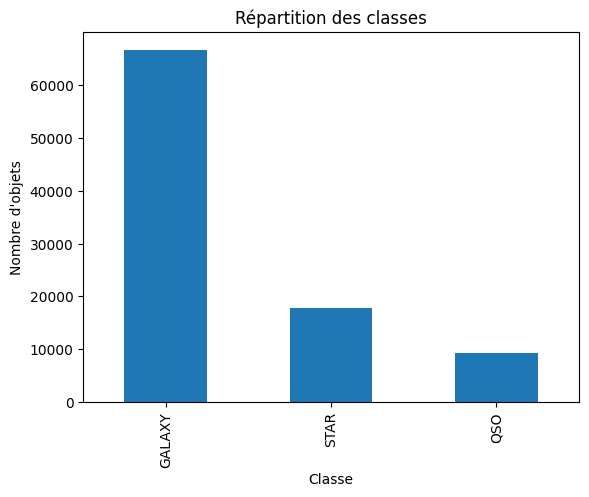

In [10]:

df["class"].value_counts().plot(kind="bar", title="Répartition des classes")
plt.xlabel("Classe")
plt.ylabel("Nombre d'objets")
plt.show()

In [11]:
print(df["class"].value_counts())

class
GALAXY    66662
STAR      17755
QSO        9321
Name: count, dtype: int64



Ce code affiche le nombre d’objets pour chaque classe dans le DataFrame :

- **GALAXY** : 66 662 objets
- **STAR** : 17 755 objets
- **QSO** : 9 321 objets

Cela permet de visualiser le déséquilibre éventuel entre les différentes classes d’objets célestes.



### Distribution du redshift


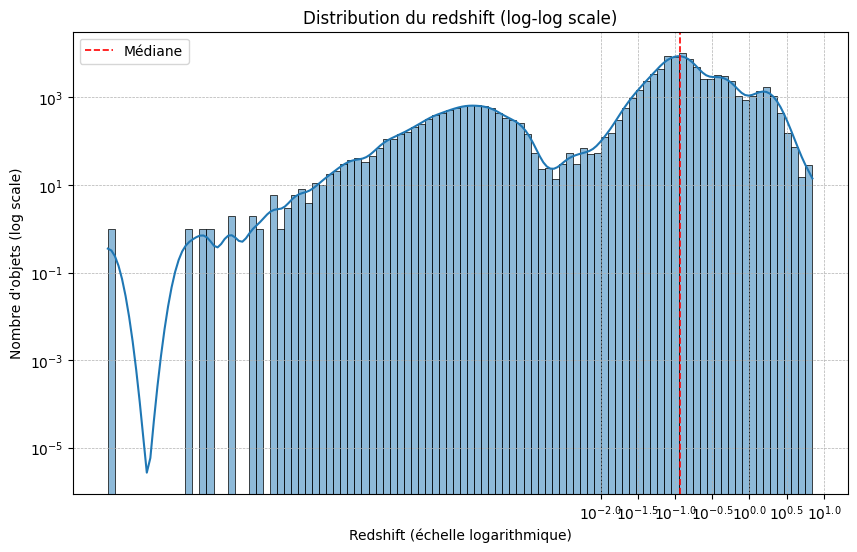

In [12]:
import matplotlib.ticker as ticker

plt.figure(figsize=(10, 6))
# Appliquer log sur les données pour que le binning respecte l’échelle log
log_redshift = np.log10(df["redshift"][df["redshift"] > 0])  # éviter log(0)
log_redshift = log_redshift[~np.isinf(log_redshift)]
sns.histplot(log_redshift, bins=100, kde=True)

# Corriger les labels des axes pour qu’ils soient en valeurs originales (non-log)
plt.xticks(ticks=np.arange(-2, 1.2, 0.5), labels=[f"$10^{{{i}}}$" for i in np.arange(-2, 1.2, 0.5)])
plt.yscale("log")

plt.title("Distribution du redshift (log-log scale)")
plt.xlabel("Redshift (échelle logarithmique)")
plt.ylabel("Nombre d'objets (log scale)")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)

median = np.median(log_redshift)
plt.axvline(median, color='red', linestyle='--', linewidth=1.2, label='Médiane')
plt.legend(loc='upper left')
plt.show()



Le graphique ci-dessus montre la distribution du logarithme du redshift (`log10(redshift)`), représentée en échelle log-log.  
Cela permet de mieux visualiser la répartition des objets célestes en fonction de leur distance.

On observe une forte concentration d’objets avec des redshifts compris entre $10^{-1.5}$ et $10^{-0.5}$ (environ 0.03 à 0.3), avec un **pic situé autour de $10^{-1}$ en abscisse (soit un redshift ≈ 0.1), atteignant une hauteur d’environ $10^{3.5}$ objets**.  
Cela signifie que la majorité des objets dans notre jeu de données sont des galaxies situées dans l’univers proche, à l’échelle cosmologique.  
À l’inverse, les objets avec un redshift supérieur à $10^0$ (soit > 1), comme les quasars très lointains, sont beaucoup plus rares.

#### Conséquences pour l’analyse :
- La variable `redshift` est très **déséquilibrée** : on observe beaucoup plus de galaxies proches que d’objets très éloignés.
- Si on utilise ces données sans traitement, le modèle risque de prédire surtout les petites valeurs.
- Pour corriger cela, on peut :
  - **appliquer une transformation logarithmique** au redshift pour mieux répartir les valeurs,
  - **filtrer ou limiter l’impact des extrêmes** (par exemple les quasars),
  - ou simplement **garder cette asymétrie à l’esprit** lors de l’évaluation du modèle.



### Distribution du redshift par classe

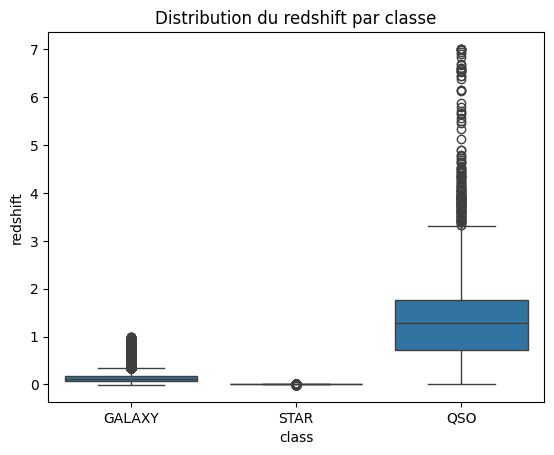

In [13]:
sns.boxplot(x="class", y="redshift", data=df)
plt.title("Distribution du redshift par classe")
plt.show()

Ce boxplot compare la distribution du `redshift` selon les trois classes d’objets célestes (`GALAXY`, `STAR`, `QSO`) :

- Les étoiles (`STAR`) ont un redshift quasi nul, ce qui est attendu puisqu’elles appartiennent à notre propre galaxie.
- Les galaxies (`GALAXY`) présentent un redshift modéré, généralement inférieur à 0.5.
- Les quasars (`QSO`) ont des redshifts nettement plus élevés, souvent supérieurs à 1, avec une large variabilité. Ce sont des objets très lointains.

On remarque également la présence de nombreux points isolés au-dessus des boîtes (notamment pour les quasars) :  
ce sont des **valeurs aberrantes**, c’est-à-dire des objets dont le redshift est très éloigné de la majorité des valeurs de leur classe.

- Pour les `QSO`, ces valeurs extrêmes correspondent à des quasars très lointains, avec un redshift parfois supérieur à 6 ou 7.
- Pour les `GALAXY` ou `STAR`, ces points peuvent aussi indiquer des cas rares ou mal classés, qu’il peut être pertinent de vérifier ou de filtrer selon le contexte.


Ce graphique confirme que le `redshift` est une variable discriminante entre les classes. Il met aussi en évidence la nécessité d’être attentif aux **valeurs extrêmes**, qui peuvent influencer certains modèles de manière disproportionnée. Enfin, il justifie le filtrage des étoiles dans un modèle de régression du redshift, puisqu’elles n’apportent pas de diversité utile (leur redshift reste toujours proche de 0).



### Matrice de corrélation

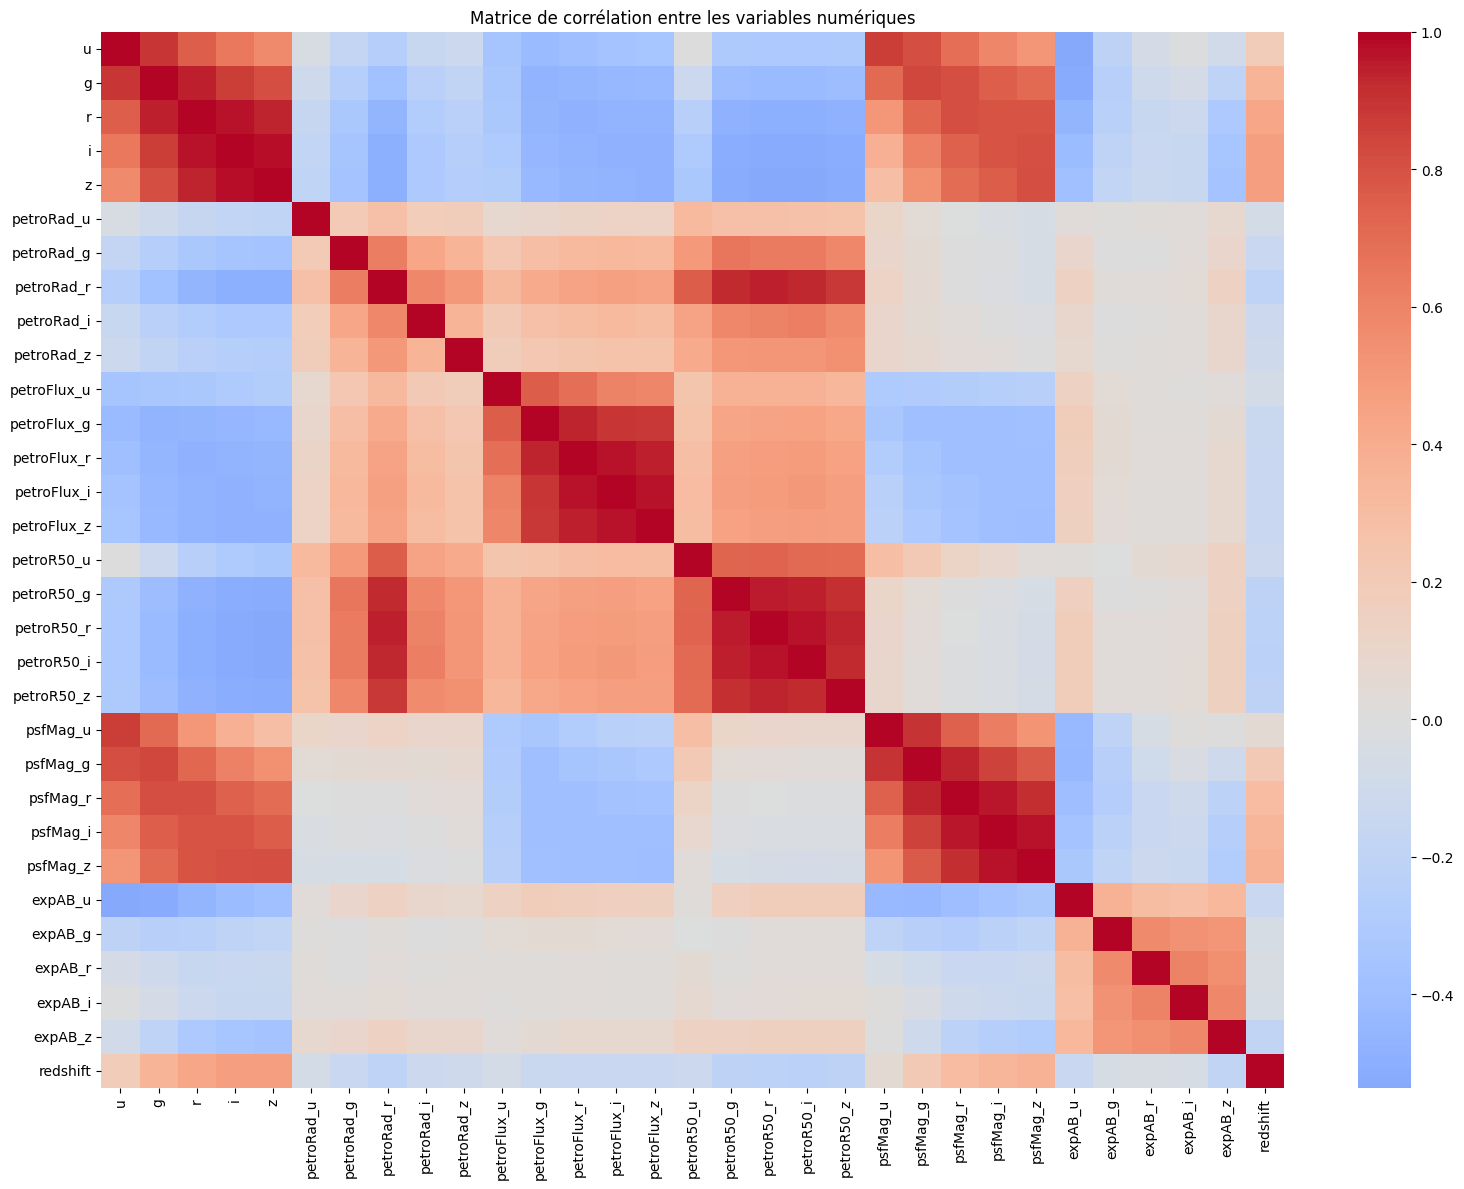

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# On ne garde que les colonnes numériques
numeric_df = df.select_dtypes(include=["float64", "int64"])

# Calcul de la matrice de corrélation
corr_matrix = numeric_df.corr()

# Affichage de la heatmap
plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, cmap="coolwarm", annot=False, center=0)
plt.title("Matrice de corrélation entre les variables numériques")
plt.tight_layout()
plt.show()


Cette matrice de corrélation, calculée uniquement sur les variables physiques (après suppression des colonnes techniques), met en évidence plusieurs points clés :
- Les magnitudes (`u`, `g`, `r`, `i`, `z`) et les flux (`petroFlux_*`) sont fortement corrélés entre eux, ce qui confirme leur redondance partielle.
- Le `redshift` n’est fortement corrélé à aucune variable individuelle, ce qui suggère que la relation entre les caractéristiques physiques et le décalage spectral est complexe et non linéaire.
- Les variables les plus corrélées négativement à `redshift` sont `petroRad_r`, `petroFlux_i`, `petroFlux_g`, `psfMag_r`, ce qui justifie leur utilisation dans un modèle de régression.
- Les variables de forme (`expAB_*`) sont très corrélées entre elles, mais peu liées au redshift — leur utilité sera à vérifier empiriquement lors de l'entraînement.

Cette analyse nous permet de mieux sélectionner les variables pertinentes et d’envisager, si besoin, des techniques de réduction de dimension ou de régularisation pour éviter les redondances.


### Corrélation entre les variables et le redshift


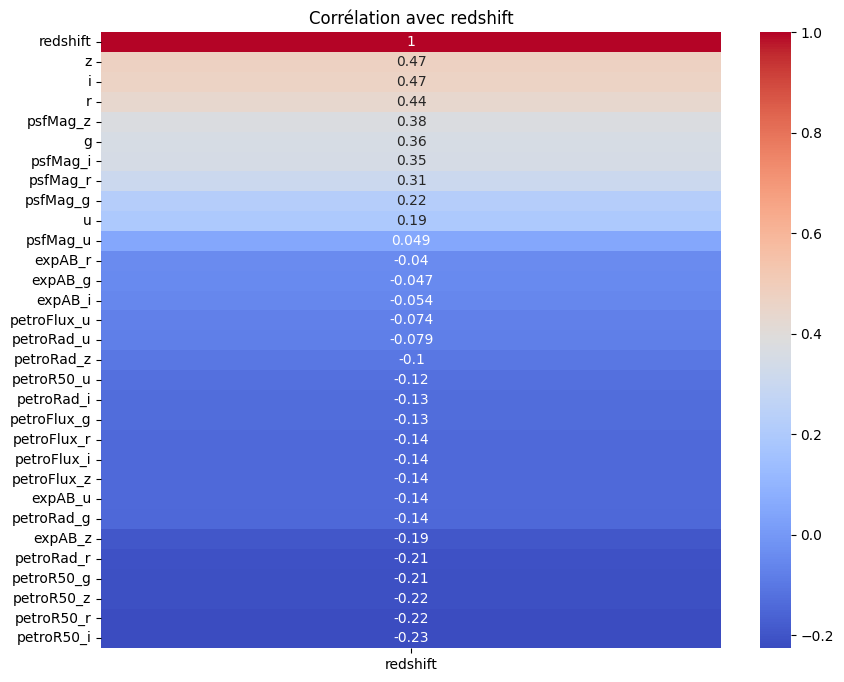

In [15]:
corr = df.corr(numeric_only=True)
plt.figure(figsize=(10, 8))
sns.heatmap(corr[["redshift"]].sort_values("redshift", ascending=False), annot=True, cmap="coolwarm")
plt.title("Corrélation avec redshift")
plt.show()


Cette heatmap montre la corrélation linéaire de chaque variable avec le `redshift`. Les valeurs proches de +1 indiquent une forte corrélation positive, tandis que celles proches de -1 indiquent une corrélation négative.

#### Principales observations :
- Les variables **`z`**, **`i`** et **`r`** (magnitudes classiques) sont les **plus corrélées positivement** avec le redshift (≈ 0.44 à 0.47).
- Les **magnitudes PSF** sont aussi corrélées, mais un peu moins (max ≈ 0.38 pour `psfMag_z`).
- Les autres variables (flux, rayons, positions, excentricité…) montrent une **corrélation faible voire négative**, suggérant qu'elles sont moins informatives pour la prédiction du redshift.

### Nuage de points

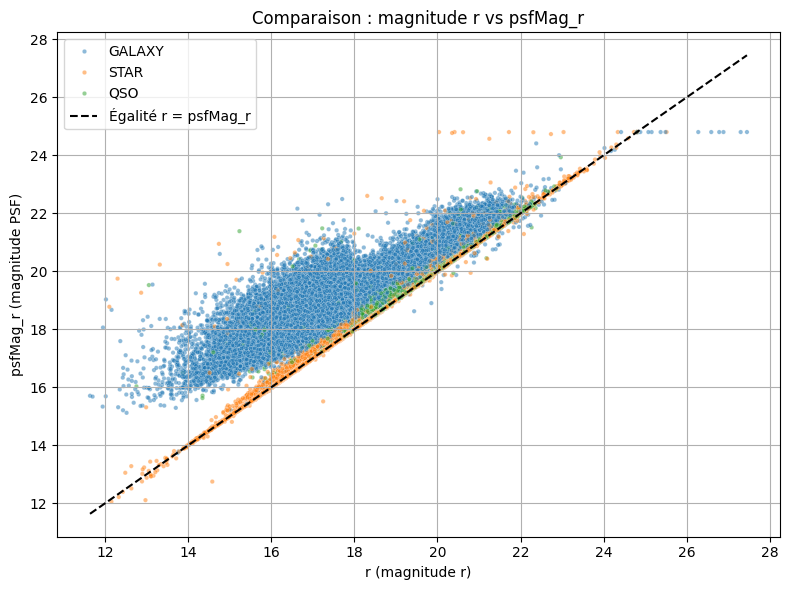

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))

# Nuage de points : r (modelMag) vs psfMag_r
sns.scatterplot(
    data=df,
    x="r",
    y="psfMag_r",
    hue="class",
    alpha=0.5,
    s=10
)

# Ligne diagonale : y = x
min_val = min(df["r"].min(), df["psfMag_r"].min())
max_val = max(df["r"].max(), df["psfMag_r"].max())
plt.plot([min_val, max_val], [min_val, max_val], 'k--', label="Égalité r = psfMag_r")

# Titres et légende
plt.title("Comparaison : magnitude r vs psfMag_r")
plt.xlabel("r (magnitude r)")
plt.ylabel("psfMag_r (magnitude PSF)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Les diagrammes de dispersion précédents comparent directement, pour chaque objet, les magnitudes classiques `r` avec les magnitudes PSF `psfMag_r`, en colorant les points par classe (`GALAXY`, `STAR`, `QSO`). Une diagonale d’égalité (`r = psfMag_r`) est tracée pour faciliter la comparaison.

On observe que :
- Les **étoiles (`STAR`)** et les **quasars (`QSO`)** sont alignés très précisément le long de cette diagonale. Cela montre que les magnitudes PSF capturent très bien leur flux lumineux. Ces objets sont ponctuels (non étendus), donc leur lumière est bien modélisée par la PSF.
- Les **galaxies (`GALAXY`)**, au contraire, se situent **au-dessus de la diagonale**, ce qui indique que `psfMag_r` est **plus élevée** (donc **moins lumineuse**) que `r`. Cela signifie que la PSF **sous-estime la luminosité** des galaxies, car elle ignore la lumière diffusée en périphérie de ces objets étendus.

Ces visualisations confirment que :
- Les magnitudes **`psfMag_*`** sont le meilleur choix pour les **étoiles** et **quasars**, car elles sont optimisées pour les objets ponctuels.
- Les magnitudes classiques (`r`, `g`, etc.), souvent dérivées de `modelMag_*`, sont plus adaptées aux **galaxies**, car elles intègrent mieux le flux total.
- Le choix des variables dépend donc de la nature de l’objet : **ponctuel ou étendu**.

> “For galaxies, modelMag usually provides the best available SDSS colors.”  
> “For distant quasars, which are unresolved, psfMag is unbiased and optimal.”  
> “Again, these objects are unresolved, and psfMag is the optimal measure of their brightness.”  
> Source: [https://www.sdss.org/dr12/algorithms/magnitudes/](https://www.sdss.org/dr12/algorithms/magnitudes/)



### Choix des magnitudes en fonction du type d'objet

- Pour les **étoiles** (`STAR`) et les **quasars** (`QSO`), nous utilisons les magnitudes `psfMag_*`, car ce sont des objets ponctuels (unresolved sources). La PSF est optimisée pour ce type de forme, ce qui permet d’obtenir une mesure plus fiable de leur luminosité.

- Pour les **galaxies** (`GALAXY`), nous utilisons les magnitudes classiques `u`, `g`, `r`, `i`, `z` (souvent dérivées de `modelMag_*`), car ces objets sont étendus. Les magnitudes PSF sous-estiment leur flux total en négligeant la lumière diffusée à la périphérie.

Ce choix permet une modélisation plus cohérente et physiquement fondée selon le type d’objet analysé.

##  Régression du redshift séparée par classe (STAR, GALAXY, QSO)


In [17]:
# Séparer le DataFrame en deux groupes selon la classe
df_star = df[df["class"] == "STAR"]
df_qso = df[df["class"] == "QSO"]
df_galaxy = df[df["class"] == "GALAXY"]

# Pour les étoiles : utiliser les magnitudes PSF
features_star= ["psfMag_u", "psfMag_g", "psfMag_r", "psfMag_i", "psfMag_z"]
X_star = df_star[features_star]
y_star = df_star["redshift"]

# Pour les QSOs : utiliser les magnitudes PSF
features_qso = ["psfMag_u", "psfMag_g", "psfMag_r", "psfMag_i", "psfMag_z"]
X_qso = df_qso[features_qso]
y_qso = df_qso["redshift"]


# Pour les galaxies : utiliser les magnitudes classiques (g, r, i, z)
features_galaxy = ["u", "g", "r", "i", "z"]
X_galaxy = df_galaxy[features_galaxy]
y_galaxy = df_galaxy["redshift"]

# Résumé des tailles de chaque dataset préparé
{
    "X_star": X_star.shape,
    "y_star": y_star.shape,
    "X_galaxy": X_galaxy.shape,
    "y_galaxy": y_galaxy.shape,
    "X_qso": X_qso.shape,
    "y_qso": y_qso.shape
}


{'X_star': (17755, 5),
 'y_star': (17755,),
 'X_galaxy': (66662, 5),
 'y_galaxy': (66662,),
 'X_qso': (9321, 5),
 'y_qso': (9321,)}

In [18]:
# Séparation train/test pour STAR, QSO et GALAXY
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(
    X_star, y_star, test_size=0.2, random_state=42
)

X_train_q, X_test_q, y_train_q, y_test_q = train_test_split(
    X_qso, y_qso, test_size=0.2, random_state=42
)

X_train_g, X_test_g, y_train_g, y_test_g = train_test_split(
    X_galaxy, y_galaxy, test_size=0.2, random_state=42
)

In [19]:
# Entraînement du modèle
model_s = RandomForestRegressor(n_estimators=100, random_state=42)
model_s.fit(X_train_s, y_train_s)

model_q = RandomForestRegressor(n_estimators=100, random_state=42)
model_q.fit(X_train_q, y_train_q)

model_g = RandomForestRegressor(n_estimators=100, random_state=42)
model_g.fit(X_train_g, y_train_g)



RandomForestRegressor(random_state=42)

In [20]:
# Prédiction
y_pred_s = model_s.predict(X_test_s)
y_pred_g = model_g.predict(X_test_g)
y_pred_q = model_q.predict(X_test_q)


In [21]:
# Évaluation
print("\nRésultats pour GALAXY :")
print("MSE :", mean_squared_error(y_test_g, y_pred_g))
print("R² :", r2_score(y_test_g, y_pred_g))

print("Résultats pour STAR:")
print("MSE :", mean_squared_error(y_test_s, y_pred_s))
print("R² :", r2_score(y_test_s, y_pred_s))

print("Résultats pour QSO:")
print("MSE :", mean_squared_error(y_test_q, y_pred_q))
print("R² :", r2_score(y_test_q, y_pred_q))



Résultats pour GALAXY :
MSE : 0.0018041347529267854
R² : 0.9034612371971326
Résultats pour STAR:
MSE : 2.2184374973607857e-07
R² : -0.08135069032246833
Résultats pour QSO:
MSE : 0.33586251163928976
R² : 0.46087693522890594


## Résultats de la prédiction du redshift par classe

Nous avons entraîné trois modèles `RandomForestRegressor` indépendants pour prédire le redshift à partir des magnitudes adaptées selon le type d’objet :  
- `psfMag_*` pour les objets ponctuels (`STAR`, `QSO`)
- `u`, `g`, `r`, `i`, `z` pour les objets étendus (`GALAXY`)

###  Résultats

| Classe   | MSE           | R²       | Interprétation rapide                         |
|----------|---------------|----------|----------------------------------------------|
| GALAXY   | 0.0018        | 0.903    |  Très bon modèle, bonne corrélation couleurs/redshift |
| STAR     | 2.2e-7        | -0.081   |  Redshift ≈ 0 → le modèle est inutile ici   |
| QSO      | 0.336         | 0.461    |  Moyen, le modèle capte une tendance mais reste imprécis |

###  Analyse :

- **GALAXY** : Les magnitudes classiques permettent une prédiction fiable du redshift. Le modèle atteint une performance très élevée (R² > 0.90), ce qui montre que les couleurs photométriques sont de bons prédicteurs.
  
- **STAR** : Les étoiles ayant un redshift quasi nul, le modèle n’apprend rien d’utile (R² < 0). Il suffit de prédire `redshift = 0` dans ce cas.

- **QSO** : Le modèle parvient à détecter une tendance globale, mais la grande dispersion des points montre que la prédiction est imprécise. Cela peut être dû à la complexité spectrale des quasars.



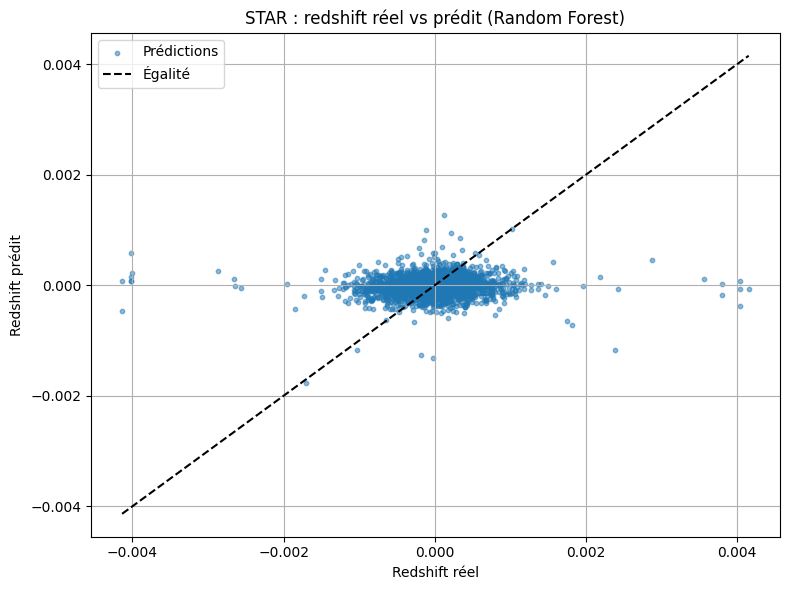

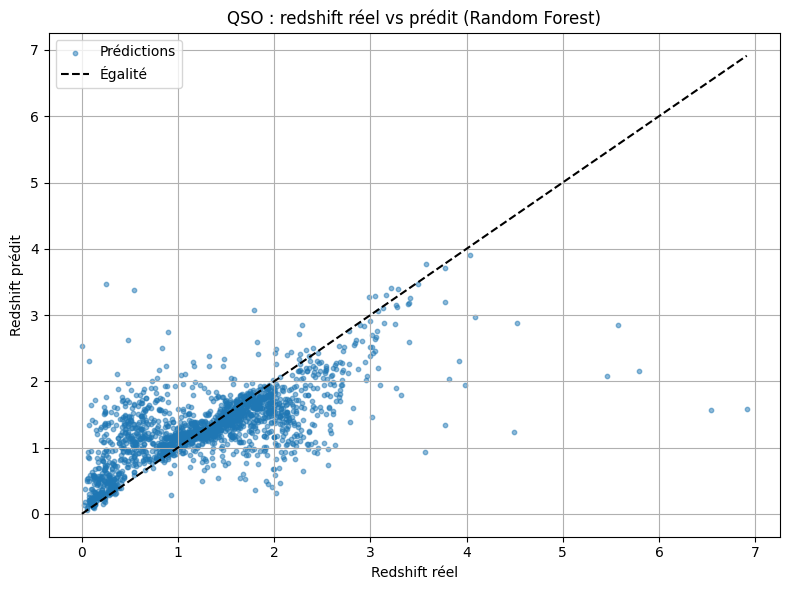

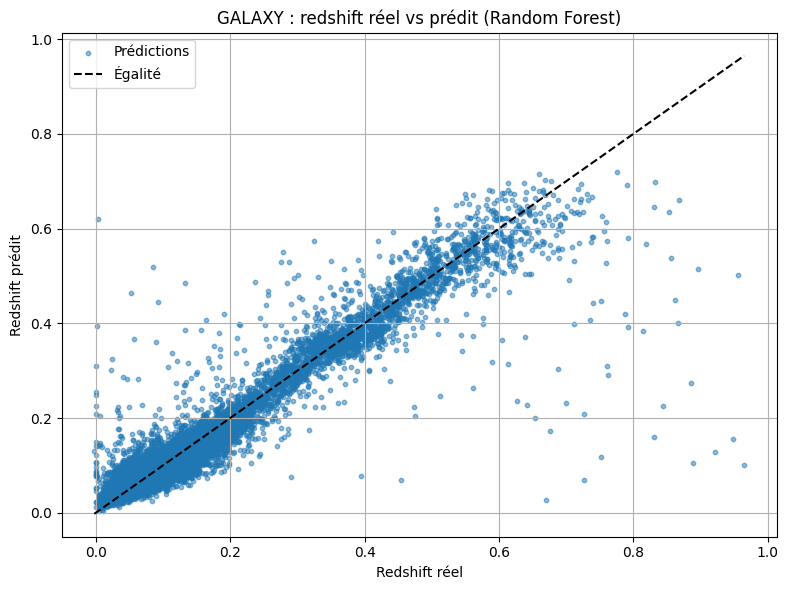

In [22]:
# 1. Graphe pour STAR (redshift ≈ 0, donc peu de dispersion attendue)
plt.figure(figsize=(8, 6))
plt.scatter(y_test_s, y_pred_s, alpha=0.5, s=10, label="Prédictions")
plt.plot([y_test_s.min(), y_test_s.max()], [y_test_s.min(), y_test_s.max()], 'k--', label="Égalité")
plt.title("STAR : redshift réel vs prédit (Random Forest)")
plt.xlabel("Redshift réel")
plt.ylabel("Redshift prédit")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 2. Graphe pour QSO
plt.figure(figsize=(8, 6))
plt.scatter(y_test_q, y_pred_q, alpha=0.5, s=10, label="Prédictions")
plt.plot([y_test_q.min(), y_test_q.max()], [y_test_q.min(), y_test_q.max()], 'k--', label="Égalité")
plt.title("QSO : redshift réel vs prédit (Random Forest)")
plt.xlabel("Redshift réel")
plt.ylabel("Redshift prédit")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 3. Graphe pour GALAXY
plt.figure(figsize=(8, 6))
plt.scatter(y_test_g, y_pred_g, alpha=0.5, s=10, label="Prédictions")
plt.plot([y_test_g.min(), y_test_g.max()], [y_test_g.min(), y_test_g.max()], 'k--', label="Égalité")
plt.title("GALAXY : redshift réel vs prédit (Random Forest)")
plt.xlabel("Redshift réel")
plt.ylabel("Redshift prédit")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Visualisation des prédictions : redshift réel vs prédit

Nous avons tracé un nuage de points pour chaque classe d’objet, comparant le redshift réel (obtenu par spectroscopie) et le redshift prédit par notre modèle Random Forest.

---

### GALAXY

- Les points suivent une **diagonale bien marquée**, ce qui montre une bonne correspondance entre les valeurs prédites et les vraies.
- Il y a une **faible dispersion** pour les redshifts < 0.6, ce qui est cohérent avec l’évaluation (R² ≈ 0.90).
- Quelques valeurs sont surévaluées ou sous-évaluées aux extrémités, mais globalement le modèle est fiable pour ce type d’objet.

---

### STAR

- Les redshifts réels sont tous très proches de zéro (ce qui est attendu pour les étoiles).
- Le modèle prédit des valeurs proches de zéro mais **sans réel gain d’apprentissage**, ce qui explique le R² négatif.
- Cela confirme qu’un modèle est inutile ici : on peut simplement fixer `redshift = 0` pour tous les objets de type `STAR`.

---

### QSO

- Une **tendance croissante** est visible : le modèle apprend partiellement la structure du redshift des quasars.
- Cependant, la **dispersion est importante**, surtout pour les redshifts > 2.
- Le modèle a du mal à bien capturer les cas complexes (déplacement spectral variable selon la nature du quasar).
- Cela correspond à un R² ≈ 0.46 : le modèle fonctionne, mais reste très perfectible.

---

On constate que le modèle de régression Random Forest donne d’excellents résultats pour les galaxies, avec une forte corrélation entre les valeurs prédites et les valeurs réelles du redshift. Pour les étoiles, la prédiction du redshift n’apporte aucune valeur ajoutée, car leur redshift est toujours quasi nul : il suffit donc de fixer cette valeur à zéro pour tous les objets de type STAR. Concernant les quasars, le modèle parvient à capter une tendance générale, mais la dispersion reste importante, en particulier pour les objets très lointains. Cela montre que la prédiction du redshift des quasars à partir des seules magnitudes photométriques reste un défi, et qu’il serait pertinent d’explorer d’autres variables ou des modèles plus complexes pour améliorer la performance sur cette classe.
En conclusion, la prédiction du redshift à partir des magnitudes photométriques est réaliste pour les galaxies, plus difficile pour les quasars, et non pertinente pour les étoiles. Cela souligne l’importance d’un traitement différencié par classe, tant pour la sélection des variables que pour le choix du modèle.




### Comparaison de la classification des objets avec ou sans redshift

Rapport de classification :
              precision    recall  f1-score   support

      GALAXY       0.98      0.99      0.98      1462
         QSO       0.92      0.77      0.83       201
        STAR       0.88      0.94      0.91       337

    accuracy                           0.96      2000
   macro avg       0.93      0.90      0.91      2000
weighted avg       0.96      0.96      0.95      2000



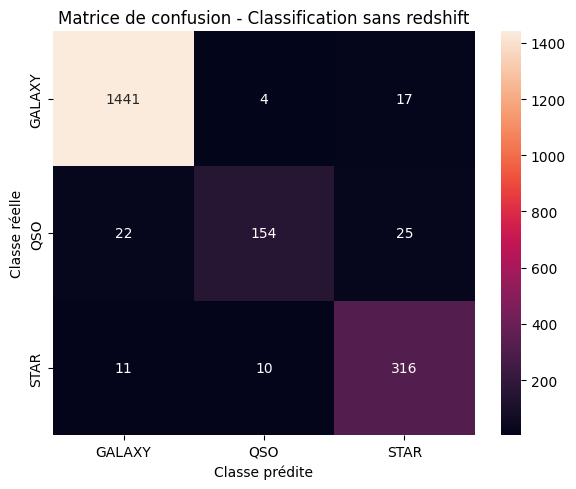

In [ ]:
#Sans le 'redshift' des features
features_classif = [
    "u", "g", "r", "i", "z",
    "petroRad_u", "petroRad_g", "petroRad_r", "petroRad_i", "petroRad_z",
    "petroFlux_u", "petroFlux_g", "petroFlux_r", "petroFlux_i", "petroFlux_z",
    "petroR50_u", "petroR50_g", "petroR50_r", "petroR50_i", "petroR50_z",
    "psfMag_u", "psfMag_g", "psfMag_r", "psfMag_i", "psfMag_z",
    "expAB_u", "expAB_g", "expAB_r", "expAB_i", "expAB_z",
]

features_classif = [f for f in features_classif if f in df.columns]

# Sous-échantillonnage
df_sampled = df.sample(n=10000, random_state=42)
X = df_sampled[features_classif]
y = df_sampled["class"]

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entraînement
clf = RandomForestClassifier(n_estimators=100, class_weight="balanced", random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# Rapport et matrice de confusion
report = classification_report(y_test, y_pred, output_dict=False)
conf_matrix = confusion_matrix(y_test, y_pred)

# Affichage
print("Rapport de classification :")
print(report)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.title("Matrice de confusion - Classification sans redshift")
plt.xlabel("Classe prédite")
plt.ylabel("Classe réelle")
plt.tight_layout()
plt.show()

Rapport de classification :
              precision    recall  f1-score   support

      GALAXY       0.97      0.96      0.97      1462
         QSO       0.75      0.79      0.77       201
        STAR       0.99      0.99      0.99       337

    accuracy                           0.95      2000
   macro avg       0.90      0.92      0.91      2000
weighted avg       0.95      0.95      0.95      2000



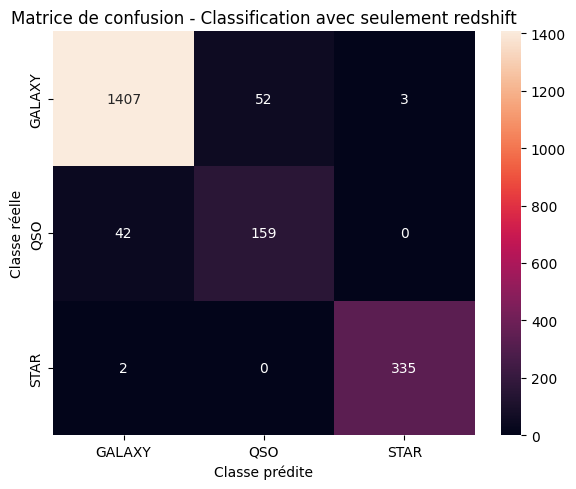

In [ ]:
#Avec seulement redshift comme feature
features_classif = [
    "redshift"
]

features_classif = [f for f in features_classif if f in df.columns]


# Sous-échantillonnage
df_sampled = df.sample(n=10000, random_state=42)
X = df_sampled[features_classif]
y = df_sampled["class"]

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entraînement
clf = RandomForestClassifier(n_estimators=100, class_weight="balanced", random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# Rapport et matrice de confusion
report = classification_report(y_test, y_pred, output_dict=False)
conf_matrix = confusion_matrix(y_test, y_pred)

# Affichage
print("Rapport de classification :")
print(report)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.title("Matrice de confusion - Classification avec seulement redshift")
plt.xlabel("Classe prédite")
plt.ylabel("Classe réelle")
plt.tight_layout()
plt.show()

### Comparaison de la classification avec et sans le redshift

Dans cette partie, nous avons testé deux modèles de classification (Random Forest) pour prédire la classe des objets célestes (STAR, GALAXY, QSO) :

#### 1. Modèle **sans utiliser le redshift**

- On a utilisé uniquement les caractéristiques photométriques disponibles : les magnitudes (`u`, `g`, `r`, `i`, `z`), les flux, les rayons et les formes des objets.
- Ce modèle a obtenu une **accuracy de 96 %**.
- Il classe très bien les étoiles et les galaxies.
- Les quasars sont un peu plus difficiles à distinguer (f1-score ≈ 0.83), mais les résultats restent corrects.

#### 2. Modèle **avec uniquement le redshift**

- Cette fois, on a utilisé uniquement la variable `redshift` comme entrée du modèle.
- Les résultats sont assez bons : **accuracy de 95 %**.
- Le modèle reconnaît très bien les étoiles, car leur redshift est toujours proche de zéro.
- Par contre, il a plus de mal à bien séparer galaxies et quasars, car leurs redshifts peuvent être similaires.

---

### Bilan

- Le redshift est une **variable très discriminante** pour détecter les étoiles.
- Mais il ne suffit **pas à lui seul** pour bien différencier quasars et galaxies.
- Le modèle qui combine plusieurs variables photométriques est plus fiable et équilibré pour prédire correctement les trois classes.

En résumé, on a vu que le redshift est utile, mais que **l’utilisation de plusieurs paramètres donne de meilleurs résultats**, surtout pour les classes plus complexes comme les quasars.



### Conclusion

On a pu explorer un jeu de données réel provenant du relevé SDSS qui combine des mesures photométriques et spectroscopiques. On a u construire un modèle de Machine Learning capable de prédire le redshift des galaxies et des quasars, une variable essentielle pour estimer leur distance et leur position dans l'univers.

Notre modèle se base principalement sur les données photométriques, ce qui est utile dans le cas ou les données spectrales sont absentes ou incomplètes.


### Pistes d'amélioration

- Enrichir le modèles avec d'autres caractéristiques physiques ;
- Appliquer des techniques de réduction de dimension (ex : PCA) pour mieux visualiser les groupes d'objets ;
- Utiliser les spectres complets (fichiers ````.fits```) comme entrées pour une modélisation plus fine.

---

## Réalisé par


***Groupe :***
- Flavio DANTAS DE SENA
- Mohammad ALI
- Mohamed Dhia DRIDI

---